## Data Science Final Project : Glove
### Group Members : Jiachang Shi, Boyuan Sun, Xiangru Shu

### Library Used

In [97]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import string
import ast
import re
import warnings
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from meter import score, score_thres, plot_learning_curve
import seaborn as sns
warnings.filterwarnings('ignore')

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, LSTM, Dropout, RNN
from keras.models import Model, Sequential
from keras.optimizers import SGD, RMSprop, Adam

### Data Proprocessing

In [2]:
# read in data
imdb_movie = pd.read_csv('data/imdb_multilabel.csv')

# drop movies with unknown plot
imdb_movie['plot'] = imdb_movie['plot'].apply(lambda sentence: 'drop' if (('plot ' in sentence.lower()) 
                                              and ('unknown' in sentence.lower()))
                                              or (len(sentence.split()) < 100) 
                                              else sentence)
imdb_movie = imdb_movie[imdb_movie['plot'] != 'drop']

# single-label encoding
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

# multi-label encoded as an array
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros(20)
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return list(encode)

imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].apply(multi_label_encoder)
imdb_movie['plot_list'] = imdb_movie['plot_list'].apply(ast.literal_eval)

# train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_movie['plot'], 
                                                    imdb_movie['all_genre_encode'],
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    stratify = imdb_movie['genre'],
                                                    shuffle = True
                                                    )

# reshape y_train and y_test
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

##  Models - Glove Representation of Words

In [3]:
with open("glove.6B.300d.txt", "rb") as lines:
    w2v = {line.decode("utf-8").split()[0]: np.array(line.split()[1:]).astype(float)
           for line in lines}

In [4]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300


    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in re.sub('['+string.punctuation+']', '', words.strip()) if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

mean_embed = MeanEmbeddingVectorizer(w2v)
glove_X_train = mean_embed.transform(X_train)
glove_X_test = mean_embed.transform(X_test)

In [91]:
# from collections import defaultdict
# class TfidfEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.word2weight = None
#         self.dim = 300

#     def fit(self, X):
#         tfidf = TfidfVectorizer(analyzer=lambda x: x)
#         tfidf.fit(X)
#         # if a word was never seen - it must be at least as infrequent
#         # as any of the known words - so the default idf is the max of 
#         # known idf's
#         max_idf = max(tfidf.idf_)
#         self.word2weight = defaultdict(
#             lambda: max_idf,
#             [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

#         return self

#     def transform(self, X):
#         return np.array([
#                 np.mean([self.word2vec[w] * self.word2weight[w]
#                          for w in words if w in self.word2vec] or
#                         [np.zeros(self.dim)], axis=0)
#                 for words in X
#             ])
    
# tf_embed = TfidfEmbeddingVectorizer(w2v)
# tf_embed.fit(X_train)
# glove_X_train = tf_embed.transform(X_train)
# glove_X_test = tf_embed.transform(X_test)

In [6]:
glove_X_train.shape

(3489, 300)

### Random Forests

In [8]:
rf_tuning_parameters = {'estimator__n_estimators':[50, 100, 200], 
                        'estimator__max_depth':[100, 200, 500]}

In [10]:
rf = OneVsRestClassifier(RandomForestClassifier())
rf = GridSearchCV(rf, param_grid = rf_tuning_parameters, cv=5, n_jobs=-1)
rf.fit(glove_X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__n_estimators': [50, 100, 200], 'estimator__max_depth': [100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
rf.best_params_

{'estimator__max_depth': 100, 'estimator__n_estimators': 200}

In [13]:
# save model
filename = 'rf_glove.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [14]:
# load the model from disk
loaded_rf = pickle.load(open(filename, 'rb'))

In [15]:
rf_train_pred = loaded_rf.predict(glove_X_train)
rf_test_pred = loaded_rf.predict(glove_X_test)

In [16]:
# evaluation
print('Random Forest Avg Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'avg')))
print('Random Forest Exact Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'exact')))
print('Random Forest Precision on train : {}'.format(score(y_train, rf_train_pred, 'precision')))
print('Random Forest Recall on train : {}'.format(score(y_train, rf_train_pred, 'recall')))
print('Random Forest Hit Rate on train : {}'.format(score(y_train, rf_train_pred, 'hit')))
print('Random Forest F1 Score on train : {}'.format(score(y_train, rf_train_pred, 'f1')))

Random Forest Avg Accuracy on train : 1.0
Random Forest Exact Accuracy on train : 1.0
Random Forest Precision on train : 1.0
Random Forest Recall on train : 1.0
Random Forest Hit Rate on train : 1.0
Random Forest F1 Score on train : 1.0


In [17]:
# evaluation
print('Random Forest Avg Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'avg')))
print('Random Forest Exact Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'exact')))
print('Random Forest Precision on test : {}'.format(score(y_test, rf_test_pred, 'precision')))
print('Random Forest Recall on test : {}'.format(score(y_test, rf_test_pred, 'recall')))
print('Random Forest Hit Rate on test : {}'.format(score(y_test, rf_test_pred, 'hit')))
print('Random Forest F1 Score on test : {}'.format(score(y_test, rf_test_pred, 'f1')))

Random Forest Avg Accuracy on test : 0.8443298969072164
Random Forest Exact Accuracy on test : 0.022909507445589918
Random Forest Precision on test : 0.38128799482128695
Random Forest Recall on test : 0.05117877454390081
Random Forest Hit Rate on test : 0.434135166093929
Random Forest F1 Score on test : 0.09024440121445072


### Logistic Regression

In [19]:
lr = OneVsRestClassifier(LogisticRegressionCV(cv = 5))
lr.fit(glove_X_train, y_train)
lr_train_pred = lr.predict(glove_X_train)
lr_test_pred = lr.predict(glove_X_test)

In [20]:
# save model
filename = 'lr_glove.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [21]:
# load the model from disk
loaded_lr = pickle.load(open(filename, 'rb'))

In [22]:
# evaluation
print('Logistic Regression Avg Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'avg')))
print('Logistic Regression Exact Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'exact')))
print('Logistic Regression Precision on train : {}'.format(score(y_train, lr_train_pred, 'precision')))
print('Logistic Regression Recall on train : {}'.format(score(y_train, lr_train_pred, 'recall')))
print('Logistic Regression Hit Rate on test : {}'.format(score(y_train,lr_train_pred, 'hit')))
print('Logistic Regression F1 Score on test : {}'.format(score(y_train, lr_train_pred, 'f1')))

Logistic Regression Avg Accuracy on train : 0.850902837489252
Logistic Regression Exact Accuracy on train : 0.025508741759816565
Logistic Regression Precision on train : 0.49102516368430926
Logistic Regression Recall on train : 0.06456805635475486
Logistic Regression Hit Rate on test : 0.49297793063915163
Logistic Regression F1 Score on test : 0.11412860811419565


In [23]:
# evaluation
print('Logistic Regression Avg Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'avg')))
print('Logistic Regression Exact Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'exact')))
print('Logistic Regression Precision on test : {}'.format(score(y_test, lr_test_pred, 'precision')))
print('Logistic Regression Recall on test : {}'.format(score(y_test, lr_test_pred, 'recall')))
print('Logistic Regression Hit Rate on test : {}'.format(score(y_test, lr_test_pred, 'hit')))
print('Logistic Regression F1 Score on test : {}'.format(score(y_test, lr_test_pred, 'f1')))

Logistic Regression Avg Accuracy on test : 0.8460481099656357
Logistic Regression Exact Accuracy on test : 0.024054982817869417
Logistic Regression Precision on test : 0.2552112387653064
Logistic Regression Recall on test : 0.059678851243138896
Logistic Regression Hit Rate on test : 0.47308132875143183
Logistic Regression F1 Score on test : 0.09673669662607318


### SVM

In [66]:
svm_tuning_parameters = {'estimator__C': [0.1, 5, 50, 100, 1000],
                         'estimator__kernel': ['rbf']}
svm = OneVsRestClassifier(SVC())
svm = GridSearchCV(svm, param_grid = svm_tuning_parameters, cv=5, n_jobs=-1)

In [67]:
svm.fit(glove_X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__C': [0.1, 5, 50, 100, 1000], 'estimator__kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
# save model
filename = 'svm_glove.pkl'
pickle.dump(svm, open(filename, 'wb'))

In [69]:
loaded_svm = pickle.load(open(filename, 'rb'))

In [70]:
svm_train_pred = loaded_svm.predict(glove_X_train)
svm_test_pred = loaded_svm.predict(glove_X_test)

In [71]:
# evaluation
print('SVM Avg Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'avg')))
print('SVM Exact Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'exact')))
print('SVM Precision on train : {}'.format(score(y_train, svm_train_pred, 'precision')))
print('SVM Recall on train : {}'.format(score(y_train, svm_train_pred, 'recall')))
print('SVM Hit Rate on train : {}'.format(score(y_train,lr_train_pred, 'hit')))
print('SVM F1 Score on train : {}'.format(score(y_train, lr_train_pred, 'f1')))

SVM Avg Accuracy on train : 0.8427199770707939
SVM Exact Accuracy on train : 0.02722843221553454
SVM Precision on train : 0.026769848094009747
SVM Recall on train : 0.05
SVM Hit Rate on train : 0.49297793063915163
SVM F1 Score on train : 0.11412860811419565


In [72]:
# evaluation
print('SVM Avg Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'avg')))
print('SVM Exact Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'exact')))
print('SVM Precision on test : {}'.format(score(y_test, svm_test_pred, 'precision')))
print('SVM Recall on test : {}'.format(score(y_test, svm_test_pred, 'recall')))
print('SVM Hit Rate on test : {}'.format(score(y_test, svm_test_pred, 'hit')))
print('SVM F1 Score on test : {}'.format(score(y_test, svm_test_pred, 'f1')))

SVM Avg Accuracy on test : 0.8403780068728522
SVM Exact Accuracy on test : 0.026345933562428408
SVM Precision on test : 0.026403207331042382
SVM Recall on test : 0.05
SVM Hit Rate on test : 0.5280641466208477
SVM F1 Score on test : 0.034557721139430286


### Embedding Layer

In [5]:
embeddings_index = {}
with open("glove.6B.300d.txt", "rb") as f:
    for line in f:
        values = line.decode("utf-8").split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [6]:
# MAX_WORDS = 40000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300

In [7]:
train_texts = X_train.apply(lambda x: 
                            re.sub('['+string.punctuation+']', 
                                   '', x.strip())).values

In [8]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

In [9]:
sequences = tokenizer.texts_to_sequences(train_texts)
X_glove_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [10]:
#
test_texts = X_test.apply(lambda x: 
                           re.sub('['+string.punctuation+']', 
                                  '', x.strip())).values
test_sequences = tokenizer.texts_to_sequences(test_texts)
X_glove_test = pad_sequences(test_sequences, 
                             maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
#     if i >= MAX_WORDS:
#         continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
X_glove_train.shape

(3489, 300)

### GPU Data Preparation

In [132]:
np.save('embedding_matrix.npy', embedding_matrix)
np.save('X_glove_train.npy', X_glove_train)
np.save('y_train.npy', y_train)
np.save('X_glove_test.npy', X_glove_test)
np.save('y_test.npy', y_test)

### load data

In [133]:
embedding_matrix = np.load('embedding_matrix.npy')
X_glove_train = np.load('X_glove_train.npy')
y_train = np.load('y_train.npy')
X_glove_test = np.load('X_glove_test.npy')
y_test = np.load('y_test.npy')

In [134]:
# MAX_WORDS = 40000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300

In [136]:
num_words = 44984

## CNN

In [27]:
cnn = Sequential()
e = Embedding(num_words, EMBEDDING_DIM, 
              weights=[embedding_matrix], 
              input_length=MAX_SEQUENCE_LENGTH, 
              trainable=False)
cnn.add(e)
cnn.add(Dropout(0.5))
cnn.add(Conv1D(32, 3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=3))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(20, activation='sigmoid'))

In [28]:
# compile the model
cnn.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc'])

In [29]:
cnn_history = cnn.fit(X_glove_train, y_train,
                        batch_size=128,
                        epochs=20, validation_data = (X_glove_test, y_test))

Train on 3489 samples, validate on 873 samples
Epoch 1/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.4800 - acc: 0.8014 - val_loss: 0.4578 - val_acc: 0.8407
Epoch 2/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.4256 - acc: 0.8294 - val_loss: 0.4728 - val_acc: 0.8418
Epoch 3/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.4103 - acc: 0.8373 - val_loss: 0.4534 - val_acc: 0.8428
Epoch 4/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.3968 - acc: 0.8409 - val_loss: 0.4340 - val_acc: 0.8450
Epoch 5/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.3804 - acc: 0.8457 - val_loss: 0.4108 - val_acc: 0.8510
Epoch 6/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.3671 - acc: 0.8524 - val_loss: 0.4023 - val_acc: 0.8565
Epoch 7/20
3489/3489 [==============================] - 7s 2ms/step - loss: 0.3525 - acc: 0.8566 - val_loss: 0.3775 - val_acc: 0.8604
Epoch 8/20
3489

#### convergence check

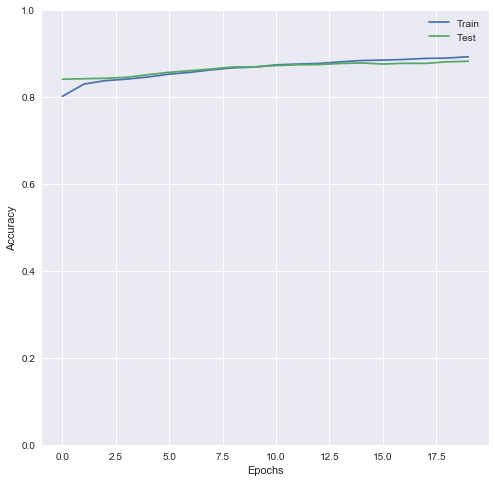

In [67]:
fig, ax = plt.subplots(figsize = (8, 8))
plot_learning_curve(cnn_history, ax)

In [96]:
# save the model
cnn.save('cnn_glove.h5')

In [98]:
cnn = load_model('cnn_glove.h5')
pred_glove_test = cnn.predict(X_glove_test)
pred_glove_train = cnn.predict(X_glove_train)

In [99]:
# evaluation
print('CNN Accuracy on train : {}'.format(score_thres(y_train, pred_glove_train, method='avg')))
print('CNN Exact Accuracy on train : {}'.format(score_thres(y_train, pred_glove_train, method='exact')))
print('CNN Precision on train : {}'.format(score_thres(y_train, pred_glove_train, method='precision')))
print('CNN Recall on train : {}'.format(score_thres(y_train, pred_glove_train, method='recall')))
print('CNN Hit Rate on train : {}'.format(score_thres(y_train, pred_glove_train, method='hit')))
print('CNN F1 on train : {}'.format(score_thres(y_train, pred_glove_train, method='f1')))

CNN Accuracy on train : 0.9145313843508168
CNN Exact Accuracy on train : 0.1877328747492118
CNN Precision on train : 0.8009106780749745
CNN Recall on train : 0.47824222616468
CNN Hit Rate on train : 0.9352249928346231
CNN F1 on train : 0.5988796247455919


In [100]:
# evaluation
print('GloVE Embedding Accuracy on test : {}'.format(score_thres(y_test, pred_glove_test, method='avg')))
print('GloVE Embedding Exact Accuracy on test : {}'.format(score_thres(y_test, pred_glove_test, method='exact')))
print('GloVE Embedding Precision on test : {}'.format(score_thres(y_test, pred_glove_test, method='precision')))
print('GloVE Embedding Recall on test : {}'.format(score_thres(y_test, pred_glove_test, method='recall')))
print('GloVE Embedding Hit Rate on train : {}'.format(score_thres(y_test, pred_glove_test, method='hit')))
print('GloVE Embedding F1 on train : {}'.format(score_thres(y_test, pred_glove_test, method='f1')))

GloVE Embedding Accuracy on test : 0.881958762886598
GloVE Embedding Exact Accuracy on test : 0.0836197021764032
GloVE Embedding Precision on test : 0.546963316146316
GloVE Embedding Recall on test : 0.3412455007995804
GloVE Embedding Hit Rate on train : 0.8625429553264605
GloVE Embedding F1 on train : 0.4202812833566325


## LSTM

In [43]:
lstm_glove = Sequential()
e = Embedding(num_words, EMBEDDING_DIM, 
              weights=[embedding_matrix], 
              input_length=MAX_SEQUENCE_LENGTH, 
              trainable=False)
lstm_glove.add(e)
lstm_glove.add(LSTM(100, dropout = 0.2, recurrent_dropout=0.2))
lstm_glove.add(Dense(20, activation='sigmoid'))

In [44]:
lstm_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          13495200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 20)                2020      
Total params: 13,657,620
Trainable params: 162,420
Non-trainable params: 13,495,200
_________________________________________________________________


In [45]:
lstm_glove.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc'])

In [50]:
lstm_history = lstm_glove.fit(X_glove_train, y_train, validation_data= (X_glove_test, y_test),
                              batch_size=128,
                              epochs=10)

Train on 3489 samples, validate on 873 samples
Epoch 1/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1769 - acc: 0.9282 - val_loss: 0.2437 - val_acc: 0.8987
Epoch 2/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1760 - acc: 0.9297 - val_loss: 0.2458 - val_acc: 0.8979
Epoch 3/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1748 - acc: 0.9294 - val_loss: 0.2445 - val_acc: 0.8981
Epoch 4/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1734 - acc: 0.9310 - val_loss: 0.2453 - val_acc: 0.8985
Epoch 5/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1715 - acc: 0.9307 - val_loss: 0.2453 - val_acc: 0.8983
Epoch 6/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1686 - acc: 0.9319 - val_loss: 0.2460 - val_acc: 0.8979
Epoch 7/10
3489/3489 [==============================] - 17s 5ms/step - loss: 0.1669 - acc: 0.9330 - val_loss: 0.2465 - val_acc: 0.8971
Epoch 8/

#### convergence check
Iteratively trained, this network is able to converge after 30 epochs.

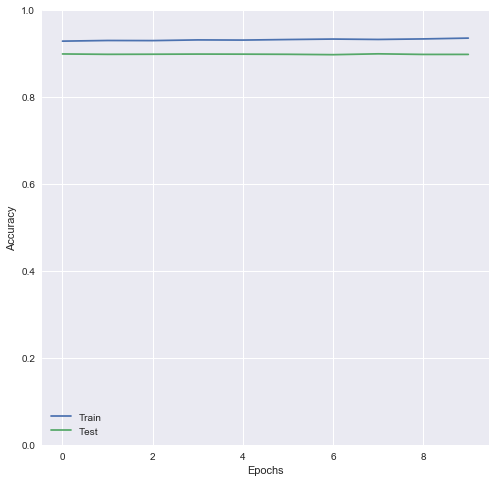

In [68]:
fig, ax = plt.subplots(figsize = (8, 8))
plot_learning_curve(lstm_history, ax)

In [101]:
# save the model
lstm_glove.save('lstm_glove.h5')

In [102]:
lstm_glove = load_model('lstm_glove.h5')
lstm_pred_glove_train = lstm_glove.predict(X_glove_train)
lstm_pred_glove_test = lstm_glove.predict(X_glove_test)

In [103]:
# evaluation
print('LSTM Accuracy on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='avg')))
print('LSTM Exact Accuracy on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='exact')))
print('LSTM Precision on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='precision')))
print('LSTM Recall on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='recall')))
print('LSTM Hit rate on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='hit')))
print('LSTM F1 on train : {}'.format(score_thres(y_train, lstm_pred_glove_train, method='f1')))

LSTM Accuracy on train : 0.9488822012037832
LSTM Exact Accuracy on train : 0.36256807108053885
LSTM Precision on train : 0.8772255234739378
LSTM Recall on train : 0.7631563928555043
LSTM Hit rate on train : 0.9936944683290341
LSTM F1 on train : 0.8162248797684287


In [104]:
# evaluation
print('LSTM Accuracy on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='avg')))
print('LSTM Exact Accuracy on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='exact')))
print('LSTM Precision on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='precision')))
print('LSTM Recall on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='recall')))
print('LSTM Hit rate on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='hit')))
print('LSTM F1 on test : {}'.format(score_thres(y_test, lstm_pred_glove_test, method='f1')))

LSTM Accuracy on test : 0.897709049255441
LSTM Exact Accuracy on test : 0.143184421534937
LSTM Precision on test : 0.6978929279911439
LSTM Recall on test : 0.560980370571585
LSTM Hit rate on test : 0.9369988545246277
LSTM F1 on test : 0.6219914804940984


## CNN + LSTM : RCNN

In [73]:
rcnn = Sequential()
e = Embedding(num_words, EMBEDDING_DIM, 
              weights=[embedding_matrix], 
              input_length=MAX_SEQUENCE_LENGTH, 
              trainable=False)
rcnn.add(e)
rcnn.add(Dropout(0.2))
rcnn.add(Conv1D(32, 5, activation='relu'))
rcnn.add(LSTM(100, recurrent_dropout=0.2))
rcnn.add(Dense(20, activation='sigmoid'))

In [74]:
rcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 300)          13495200  
_________________________________________________________________
dropout_13 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 296, 32)           48032     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                2020      
Total params: 13,598,452
Trainable params: 103,252
Non-trainable params: 13,495,200
_________________________________________________________________


In [77]:
rcnn.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc'])
rcnn_history = rcnn.fit(X_glove_train, y_train, validation_data= (X_glove_test, y_test),
               batch_size=128,
               epochs=20)

Train on 3489 samples, validate on 873 samples
Epoch 1/20
3489/3489 [==============================] - 18s 5ms/step - loss: 0.2222 - acc: 0.9070 - val_loss: 0.2691 - val_acc: 0.8854
Epoch 2/20
3489/3489 [==============================] - 17s 5ms/step - loss: 0.2187 - acc: 0.9079 - val_loss: 0.2685 - val_acc: 0.8856
Epoch 3/20
3489/3489 [==============================] - 18s 5ms/step - loss: 0.2174 - acc: 0.9088 - val_loss: 0.2675 - val_acc: 0.8862
Epoch 4/20
3489/3489 [==============================] - 19s 5ms/step - loss: 0.2158 - acc: 0.9093 - val_loss: 0.2711 - val_acc: 0.8844
Epoch 5/20
3489/3489 [==============================] - 17s 5ms/step - loss: 0.2138 - acc: 0.9107 - val_loss: 0.2684 - val_acc: 0.8853
Epoch 6/20
3489/3489 [==============================] - 17s 5ms/step - loss: 0.2143 - acc: 0.9102 - val_loss: 0.2691 - val_acc: 0.8867
Epoch 7/20
3489/3489 [==============================] - 17s 5ms/step - loss: 0.2111 - acc: 0.9123 - val_loss: 0.2662 - val_acc: 0.8871
Epoch 8/

#### convergence check
Iteratively trained, this network is able to converge after 30 epochs.

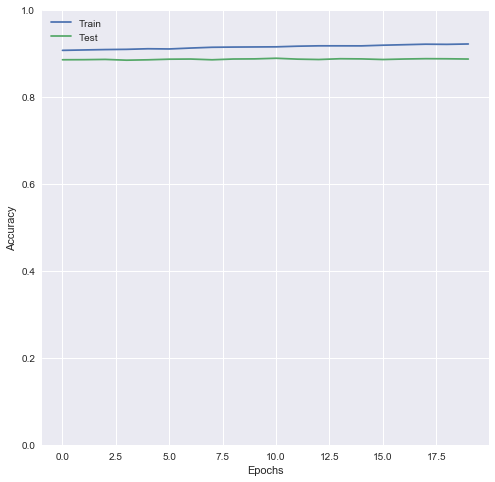

In [81]:
fig, ax = plt.subplots(figsize = (8, 8))
plot_learning_curve(rcnn_history, ax)

In [105]:
# save the model
rcnn.save('rcnn_glove.h5')

In [106]:
rcnn = load_model('rcnn_glove.h5')
rcnn_pred_glove_train = rcnn.predict(X_glove_train)
rcnn_pred_glove_test = rcnn.predict(X_glove_test)

In [107]:
# evaluation
print('RCNN Accuracy on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='avg')))
print('RCNN Exact Accuracy on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='exact')))
print('RCNN Precision on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='precision')))
print('RCNN Recall on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='recall')))
print('RCNN Hit rate on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='hit')))
print('RCNN F1 on train : {}'.format(score_thres(y_train, rcnn_pred_glove_train, method='f1')))

RCNN Accuracy on train : 0.9319575809687588
RCNN Exact Accuracy on train : 0.2530811120664947
RCNN Precision on train : 0.8266839342102775
RCNN Recall on train : 0.6342326961657299
RCNN Hit rate on train : 0.9862424763542562
RCNN F1 on train : 0.7177822054584064


In [108]:
# evaluation
print('RCNN Accuracy on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='avg')))
print('RCNN Exact Accuracy on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='exact')))
print('RCNN Precision on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='precision')))
print('RCNN Recall on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='recall')))
print('RCNN Hit rate on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='hit')))
print('RCNN F1 on test : {}'.format(score_thres(y_test, rcnn_pred_glove_test, method='f1')))

RCNN Accuracy on test : 0.8870561282932417
RCNN Exact Accuracy on test : 0.09507445589919816
RCNN Precision on test : 0.6500647052772193
RCNN Recall on test : 0.4494455377547125
RCNN Hit rate on test : 0.9014891179839634
RCNN F1 on test : 0.531452404177727
